In [1]:
eps = 0.1

epsID = -1
zeroID = 0
oneID = 1

#This means that the means are eps and slightly right of zero
ALIGNED_LEFT = 0
#This means that the means are one and around the midle of -eps and zero
ALIGNED_RIGHT= 1

CLUSTER_MASK_1 = [1,1,1]
CLUSTER_MASK_1[epsID] = 0

CLUSTER_MASK_eps = [1,1,1]
CLUSTER_MASK_eps[oneID] = 0

VALUES = [0,0,0]
VALUES[epsID]=-eps
VALUES[zeroID]=0
VALUES[oneID]=1

def eq(x,y):
    return abs(x-y)<0.00001


def com(histogram, mask, values):
    total_sum = 0
    total_elements = 0
    for i,m in enumerate(mask):
        if (m):
            total_sum+=histogram[i]*values[i]
            total_elements+= histogram[i]
    return total_sum/total_elements
    

def kmeans_loss(histogram, values, mu):
    """
    @param: mu an array of cluster centers
    @param: histogram[locID]= amount of points in location whose index is locID
    """
    loss = 0
    for i, count in enumerate(histogram):
        value = values[i]
        min_dist = min(abs(value-mu[0]), abs(value-mu[1]))
        loss += min_dist**2 * count
    return loss

def counterexample_calc_2means(histogram):
    """
    @param: histogram[locID]= amount of points in location whose index is locID
    """
    muRight = [com(histogram,CLUSTER_MASK_eps, VALUES),1]
    muLeft = [-eps,com(histogram,CLUSTER_MASK_1, VALUES)]
    return muLeft if kmeans_loss(histogram, VALUES, muLeft)<kmeans_loss(histogram,VALUES, muRight) else muRight


class FTL:
    def __init__(self, histogram):
        self.mu = self.choose_best(histogram)
        if (eq(max(self.mu),1)):
            self.alignment = ALIGNED_RIGHT
        else:
            assert(eq(min(self.mu),-eps))
            self.alignment = ALIGNED_LEFT
    
    def choose_best(self, histogram):
        if (sum(histogram)<2):
            return [-eps,0]
        else:
            return counterexample_calc_2means(histogram)
    
    def loss(self, x_t):
        tmp_hist = [0,0,0]
        tmp_hist[x_t]=1
        l_t = kmeans_loss(tmp_hist, VALUES, self.mu)
        return l_t




def FTL_adversary(ftl_obj, t, T):
    """
    @param: ftl_obj.histogram[locID]= amount of points in location whose index is locID
    @return: locID of next point in stream
    """
    #print(ftl_obj.mu, ftl_obj.alignment == ALIGNED_RIGHT)
    if (t==0):
        return epsID
    elif (t==1):
        return zeroID
         
    if (ftl_obj.alignment == ALIGNED_RIGHT):
        return epsID if min(ftl_obj.mu)>-eps/2 else zeroID
    else:
        assert(ftl_obj.alignment == ALIGNED_LEFT)
        return oneID


    
def analyze(histogram, online_loss, shouldPrint=True):
    prophet_loss = kmeans_loss(histogram, VALUES, counterexample_calc_2means(histogram))    
    regret = online_loss - prophet_loss
    
    if (shouldPrint):
        print('online loss: ', online_loss)
        print('prophet loss: ', prophet_loss)
        print('regret=',online_loss - prophet_loss)
    return (online_loss, prophet_loss, regret)

In [2]:
from math import log
import random

# MWUA: the multiplicative weights update algorithm
class MWUA_FTL:
    def __init__(self, T):
        self.FTLs = [FTL([0,0,0])]
        self.learning_rate = T**(-1/2)*log(T)
        self.histogram = [0,0,0]
        self.weights = [1]
        self.chosen_expert = None
    
    def choose(self):
        self.chosen_expert = self.FTLs[self.draw()]
    
    def observeOutcome(self, x_t):
        new_hist = self.histogram.copy()
        new_hist[x_t] += 1
        new_leader = FTL(new_hist)
        self.FTLs.append(new_leader)
        self.weights.append(1)
        for ind, count in enumerate(self.histogram):
            single_loss = new_leader.loss(ind)
            self.weights[-1] *= (1-self.learning_rate*single_loss)**count
        for i, obj in enumerate(self.FTLs):
            self.weights[i] *= (1-self.learning_rate*obj.loss(x_t))
        self.histogram = new_hist

    def loss(self,x_t):
        if (self.chosen_expert is None):
            return 1
        return self.chosen_expert.loss(x_t)

        
    def draw(self):
        choice = random.uniform(0, sum(self.weights))
        choiceIndex = 0
    
        for weight in self.weights:
            choice -= weight
            if choice <= 0:
                return choiceIndex
        
            choiceIndex += 1

In [3]:
def runFTL():
    histogram = [0,0,0]
    T=int(10000)
    loss = 0
    regret = []
    ltcount = 0
    for t in range(T):
        ftl_t = FTL(histogram)
        x_t = FTL_adversary(ftl_t,t, T)
        l_t = ftl_t.loss(x_t)
        if (l_t>0.5):
            ltcount+=1
        histogram[x_t] += 1
        loss += l_t
        if (t>0):
            _,_,regret_t = analyze(histogram, loss, False)
            regret.append(regret_t)
        #print('l_'+str(t),l_t)
    print('final regret', regret[-1])
    print('Left freq=',T/ltcount)
    return regret
regretFTL = runFTL()

final regret 25.767409669727595
Left freq= 384.61538461538464


In [4]:
def runMWUAFTL():
    histogram = [0,0,0]
    T=int(10000)
    loss = 0
    regret = []
    mwua = MWUA_FTL(T)
    for t in range(T):
        if (t%50==0):
            print ('iter',t)
        mwua.choose()
        x_t = FTL_adversary(mwua.FTLs[-1],t,T)
        mwua.observeOutcome(x_t)
        l_t = mwua.loss(x_t)
        histogram[x_t] += 1
        loss += l_t
        if (t>0):
            online,prophet,regret_t = analyze(histogram, loss, False)
            regret.append(regret_t)
        #print('l_'+str(t),l_t)
    print('final regret', regret[-1])
    print('online', online, 'prophet',prophet)
    return regret
regretMWUA = runMWUAFTL()

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450
iter 1500
iter 1550
iter 1600
iter 1650
iter 1700
iter 1750
iter 1800
iter 1850
iter 1900
iter 1950
iter 2000
iter 2050
iter 2100
iter 2150
iter 2200
iter 2250
iter 2300
iter 2350
iter 2400
iter 2450
iter 2500
iter 2550
iter 2600
iter 2650
iter 2700
iter 2750
iter 2800
iter 2850
iter 2900
iter 2950
iter 3000
iter 3050
iter 3100
iter 3150
iter 3200
iter 3250
iter 3300
iter 3350
iter 3400
iter 3450
iter 3500
iter 3550
iter 3600
iter 3650
iter 3700
iter 3750
iter 3800
iter 3850
iter 3900
iter 3950
iter 4000
iter 4050
iter 4100
iter 4150
iter 4200
iter 4250
iter 4300
iter 4350
iter 4400
iter 4450
iter 4500
iter 4550
iter 4600
iter 4650
iter 4700
iter 4750
iter 4800
iter 4850
iter 4900
iter 4950
iter 5000
iter 5050
ite

0.8821484785986833 0.995


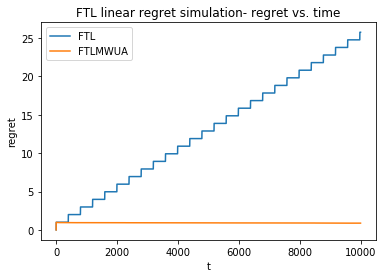

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(list(range(len(regretFTL))),regretFTL, label='FTL')
ax.plot(list(range(len(regretMWUA))),regretMWUA, label='FTLMWUA')
ax.set_xlabel('t')
ax.set_ylabel('regret')
ax.set_title('FTL linear regret simulation- regret vs. time')
print(min(regret[3:]),max(regret))
ax.legend()
fig.savefig('figures/ftl_counterexample.svg',format = 'svg', dpi = 600)#,bbox_inches = 'tight',    pad_inches = 0)
plt.show()